# 🎮 League of Legends Match Outcome Prediction
### Logistic Regression with PyTorch

**Objective:** Build a logistic regression model using PyTorch to predict League of Legends match outcomes based on in-game statistics.

---

## ⚙️ Install & Import Dependencies

In [1]:
# Install required packages
!pip install kaggle -q
!pip install torch torchvision -q

In [2]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, ConfusionMatrixDisplay)

# GPU Check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✅ Using device: {device}')
if torch.cuda.is_available():
    print(f'   GPU: {torch.cuda.get_device_name(0)}')

✅ Using device: cuda
   GPU: Tesla T4


---
## 1.1 📂 Load and Preprocess the Dataset

In [5]:
import json
from google.colab import userdata
import os

os.makedirs('/root/.kaggle', exist_ok=True)

# Write kaggle.json from secrets
kaggle_creds = {
    "username": userdata.get('prithusarkar'),
    "key": userdata.get('KAGGLE_KEY')
}

kaggle_config_path = os.path.expanduser('~/.kaggle/kaggle.json')
with open(kaggle_config_path, 'w') as f:
    json.dump(kaggle_creds, f)

os.chmod(kaggle_config_path, 0o600)
print("Kaggle credentials set from Colab Secrets!")

# Download the League of Legends dataset
!kaggle datasets download -d bobbyscience/league-of-legends-diamond-ranked-games-10-min
!unzip -o league-of-legends-diamond-ranked-games-10-min.zip
print('✅ Dataset downloaded!')

Kaggle credentials set from Colab Secrets!
Dataset URL: https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min
License(s): CC0-1.0
  0% 0.00/539k [00:00<?, ?B/s]
100% 539k/539k [00:00<00:00, 940MB/s]
Archive:  league-of-legends-diamond-ranked-games-10-min.zip
  inflating: high_diamond_ranked_10min.csv  
✅ Dataset downloaded!


In [ ]:
# ─────────────────────────────────────────────────────────
# ALTERNATIVE: If kaggle.json is not available, generate
# synthetic data with the same schema for testing purposes
# ─────────────────────────────────────────────────────────
import os

DATASET_FILE = 'high_diamond_ranked_10min.csv'

if not os.path.exists(DATASET_FILE):
    print('⚠️  Dataset file not found. Generating synthetic data for demonstration...')
    np.random.seed(42)
    n = 10000
    wins = np.random.randint(0, 2, n)
    df_synth = pd.DataFrame({
        'blueWins': wins,
        'blueWardsPlaced': np.random.randint(5, 30, n),
        'blueWardsDestroyed': np.random.randint(0, 10, n),
        'blueFirstBlood': np.random.randint(0, 2, n),
        'blueKills': np.random.poisson(6, n) + wins * 2,
        'blueDeaths': np.random.poisson(6, n) - wins * 2 + 3,
        'blueAssists': np.random.poisson(8, n),
        'blueEliteMonsters': np.random.randint(0, 3, n),
        'blueDragons': np.random.randint(0, 2, n),
        'blueHeralds': np.random.randint(0, 2, n),
        'blueTowersDestroyed': np.random.randint(0, 3, n),
        'blueTotalGold': np.random.normal(17000, 2000, n) + wins * 1500,
        'blueAvgLevel': np.random.normal(6.5, 0.5, n),
        'blueTotalExperience': np.random.normal(17000, 2000, n),
        'blueTotalMinionsKilled': np.random.normal(220, 30, n),
        'blueTotalJungleMinionsKilled': np.random.normal(55, 15, n),
        'blueGoldDiff': np.random.normal(0, 2000, n) + wins * 1500,
        'blueExperienceDiff': np.random.normal(0, 2000, n) + wins * 500,
        'blueCSPerMin': np.random.normal(22, 3, n),
        'blueGoldPerMin': np.random.normal(1700, 200, n),
        'redWardsPlaced': np.random.randint(5, 30, n),
        'redWardsDestroyed': np.random.randint(0, 10, n),
        'redFirstBlood': 1 - wins,
        'redKills': np.random.poisson(6, n) - wins * 2 + 3,
        'redDeaths': np.random.poisson(6, n) + wins * 2,
        'redAssists': np.random.poisson(8, n),
        'redEliteMonsters': np.random.randint(0, 3, n),
        'redDragons': np.random.randint(0, 2, n),
        'redHeralds': np.random.randint(0, 2, n),
        'redTowersDestroyed': np.random.randint(0, 3, n),
        'redTotalGold': np.random.normal(17000, 2000, n) - wins * 1500,
        'redAvgLevel': np.random.normal(6.5, 0.5, n),
        'redTotalExperience': np.random.normal(17000, 2000, n),
        'redTotalMinionsKilled': np.random.normal(220, 30, n),
        'redTotalJungleMinionsKilled': np.random.normal(55, 15, n),
        'redCSPerMin': np.random.normal(22, 3, n),
        'redGoldPerMin': np.random.normal(1700, 200, n),
    })
    df_synth.to_csv(DATASET_FILE, index=False)
    print(f'✅ Synthetic dataset saved as {DATASET_FILE}')
else:
    print(f'✅ Dataset found: {DATASET_FILE}')

In [6]:
# ─────────────────────────────────────────────────────────
# Load Dataset
# ─────────────────────────────────────────────────────────
df = pd.read_csv('high_diamond_ranked_10min.csv')

print(f'Dataset Shape: {df.shape}')
print(f'\nFirst 5 rows:')
df.head()

Dataset Shape: (9879, 40)

First 5 rows:


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [7]:
# ─────────────────────────────────────────────────────────
# Exploratory Data Analysis
# ─────────────────────────────────────────────────────────
print('Dataset Info:')
print(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())
print('\nClass distribution (blueWins):')
print(df['blueWins'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   in

In [8]:
# ─────────────────────────────────────────────────────────
# Preprocessing
# ─────────────────────────────────────────────────────────

# Drop gameId column if it exists (not a feature)
if 'gameId' in df.columns:
    df = df.drop(columns=['gameId'])

# Separate features and target
TARGET = 'blueWins'
X = df.drop(columns=[TARGET])
y = df[TARGET]

feature_names = X.columns.tolist()
print(f'Number of features: {len(feature_names)}')
print(f'Features: {feature_names}')

# Handle any remaining missing values
X = X.fillna(X.mean())

# Train/Validation/Test split: 70/15/15
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)  # 0.176 ≈ 15% of total

print(f'\nTrain size:      {X_train.shape[0]}')
print(f'Validation size: {X_val.shape[0]}')
print(f'Test size:       {X_test.shape[0]}')

# Feature Scaling (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Convert to PyTorch tensors and move to device
def to_tensor(arr, dtype=torch.float32):
    return torch.tensor(arr, dtype=dtype).to(device)

X_train_t = to_tensor(X_train_scaled)
y_train_t = to_tensor(y_train.values).unsqueeze(1)
X_val_t   = to_tensor(X_val_scaled)
y_val_t   = to_tensor(y_val.values).unsqueeze(1)
X_test_t  = to_tensor(X_test_scaled)
y_test_t  = to_tensor(y_test.values).unsqueeze(1)

# DataLoaders
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print('\n✅ Preprocessing complete. Tensors moved to:', device)

Number of features: 38
Features: ['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed', 'redFirstBlood', 'redKills', 'redDeaths', 'redAssists', 'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redTotalGold', 'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin']

Train size:      6919
Validation size: 1478
Test size:       1482

✅ Preprocessing complete. Tensors moved to: cuda


---
## 1.2 🧠 Logistic Regression Model (PyTorch)

In [9]:
class LogisticRegressionModel(nn.Module):
    """Logistic Regression implemented as a single linear layer + sigmoid."""

    def __init__(self, input_dim: int):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self.linear(x))


# Instantiate model and move to GPU
input_dim = X_train_t.shape[1]
model = LogisticRegressionModel(input_dim).to(device)

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f'\nTotal parameters: {total_params}')
print(f'Model is on device: {next(model.parameters()).device}')

LogisticRegressionModel(
  (linear): Linear(in_features=38, out_features=1, bias=True)
)

Total parameters: 39
Model is on device: cuda:0


---
## 1.3 🏋️ Train the Model

In [10]:
def train_model(model, train_loader, val_loader,
                optimizer, criterion, epochs=100,
                verbose=True):
    """Train and validate the model, returning history."""
    history = {'train_loss': [], 'val_loss': [],
               'train_acc': [], 'val_acc': []}

    for epoch in range(1, epochs + 1):
        # ── Training ──
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss  = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss    += loss.item() * X_batch.size(0)
            predicted      = (preds >= 0.5).float()
            train_correct += (predicted == y_batch).sum().item()
            train_total   += X_batch.size(0)

        # ── Validation ──
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                preds     = model(X_batch)
                loss      = criterion(preds, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                predicted = (preds >= 0.5).float()
                val_correct += (predicted == y_batch).sum().item()
                val_total   += X_batch.size(0)

        # Record
        t_loss = train_loss / train_total
        v_loss = val_loss   / val_total
        t_acc  = train_correct / train_total
        v_acc  = val_correct   / val_total

        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)
        history['train_acc'].append(t_acc)
        history['val_acc'].append(v_acc)

        if verbose and epoch % 10 == 0:
            print(f'Epoch [{epoch:3d}/{epochs}] | '
                  f'Train Loss: {t_loss:.4f}, Acc: {t_acc:.4f} | '
                  f'Val Loss: {v_loss:.4f}, Acc: {v_acc:.4f}')

    return history


# ── Criterion & Optimizer ──
LEARNING_RATE = 0.01
EPOCHS        = 100

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print('🚀 Starting training...')
history = train_model(model, train_loader, val_loader,
                      optimizer, criterion, epochs=EPOCHS)
print('\n✅ Training complete!')

🚀 Starting training...
Epoch [ 10/100] | Train Loss: 0.5340, Acc: 0.7267 | Val Loss: 0.5278, Acc: 0.7355
Epoch [ 20/100] | Train Loss: 0.5346, Acc: 0.7320 | Val Loss: 0.5212, Acc: 0.7382
Epoch [ 30/100] | Train Loss: 0.5335, Acc: 0.7292 | Val Loss: 0.5234, Acc: 0.7348
Epoch [ 40/100] | Train Loss: 0.5340, Acc: 0.7310 | Val Loss: 0.5233, Acc: 0.7341
Epoch [ 50/100] | Train Loss: 0.5332, Acc: 0.7283 | Val Loss: 0.5224, Acc: 0.7436
Epoch [ 60/100] | Train Loss: 0.5350, Acc: 0.7300 | Val Loss: 0.5224, Acc: 0.7382
Epoch [ 70/100] | Train Loss: 0.5333, Acc: 0.7319 | Val Loss: 0.5228, Acc: 0.7388
Epoch [ 80/100] | Train Loss: 0.5341, Acc: 0.7305 | Val Loss: 0.5204, Acc: 0.7510
Epoch [ 90/100] | Train Loss: 0.5333, Acc: 0.7335 | Val Loss: 0.5236, Acc: 0.7348
Epoch [100/100] | Train Loss: 0.5346, Acc: 0.7329 | Val Loss: 0.5228, Acc: 0.7314

✅ Training complete!


---
## 1.4 ⚡ Optimization Techniques & Model Evaluation

🚀 Training with L2 regularization + LR scheduler...

✅ Optimized training complete!

📊 Classification Report (Optimized Model):
              precision    recall  f1-score   support

    Red Wins       0.72      0.70      0.71       742
   Blue Wins       0.71      0.73      0.72       740

    accuracy                           0.72      1482
   macro avg       0.72      0.72      0.72      1482
weighted avg       0.72      0.72      0.72      1482



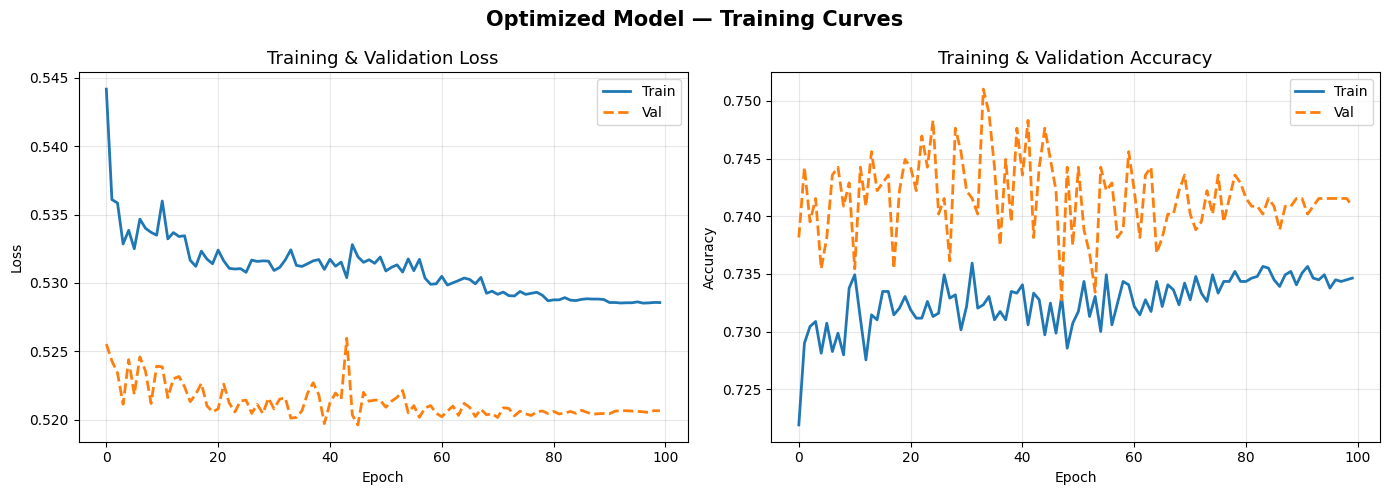

In [13]:
# ─────────────────────────────────────────────────────────
# Optimization 1: L2 Regularization (weight_decay)
# Optimization 2: Learning Rate Scheduler (ReduceLROnPlateau)
# ─────────────────────────────────────────────────────────

# Re-initialize model for a clean comparison
model_opt = LogisticRegressionModel(input_dim).to(device)

optimizer_opt = optim.Adam(model_opt.parameters(),
                           lr=LEARNING_RATE,
                           weight_decay=1e-4)   # L2 regularization

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_opt, mode='min', factor=0.5,
    patience=10)

# Custom training loop with scheduler
print('🚀 Training with L2 regularization + LR scheduler...')
history_opt = {'train_loss': [], 'val_loss': [],
               'train_acc': [], 'val_acc': []}

for epoch in range(1, EPOCHS + 1):
    model_opt.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for X_batch, y_batch in train_loader:
        optimizer_opt.zero_grad()
        preds = model_opt(X_batch)
        loss  = criterion(preds, y_batch)
        loss.backward()
        optimizer_opt.step()
        train_loss    += loss.item() * X_batch.size(0)
        train_correct += ((preds >= 0.5).float() == y_batch).sum().item()
        train_total   += X_batch.size(0)

    model_opt.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            preds     = model_opt(X_batch)
            loss      = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_correct += ((preds >= 0.5).float() == y_batch).sum().item()
            val_total   += X_batch.size(0)

    t_loss = train_loss / train_total
    v_loss = val_loss   / val_total
    scheduler.step(v_loss)

    history_opt['train_loss'].append(t_loss)
    history_opt['val_loss'].append(v_loss)
    history_opt['train_acc'].append(train_correct / train_total)
    history_opt['val_acc'].append(val_correct / val_total)

print('\n✅ Optimized training complete!')

# ── Evaluate on Test Set ──
model_opt.eval()
with torch.no_grad():
    y_probs = model_opt(X_test_t).cpu().numpy().flatten()
    y_preds = (y_probs >= 0.5).astype(int)
    y_true  = y_test.values

print('\n📊 Classification Report (Optimized Model):')
print(classification_report(y_true, y_preds, target_names=['Red Wins', 'Blue Wins']))

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, metric, title in zip(axes, ['loss', 'acc'], ['Loss', 'Accuracy']):
    ax.plot(history_opt[f'train_{metric}'], label='Train', linewidth=2)
    ax.plot(history_opt[f'val_{metric}'],   label='Val',   linewidth=2, linestyle='--')
    ax.set_title(f'Training & Validation {title}', fontsize=13)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.legend()
    ax.grid(alpha=0.3)
plt.suptitle('Optimized Model — Training Curves', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 1.5 📈 Confusion Matrix & ROC Curve

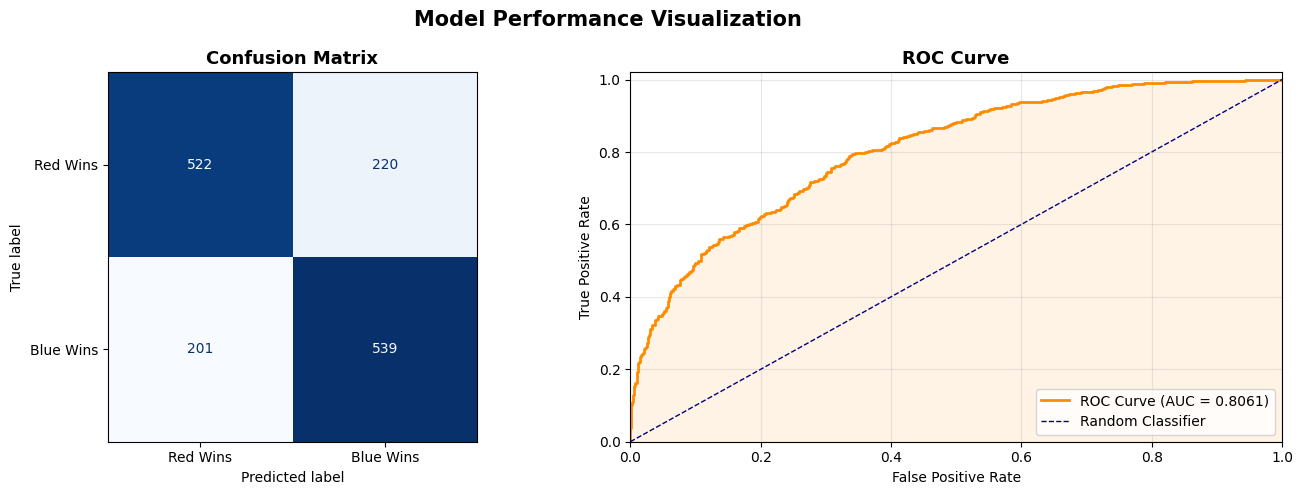


🎯 Test Accuracy : 0.7159
🎯 ROC AUC Score : 0.8061


In [14]:
# ─────────────────────────────────────────────────────────
# Confusion Matrix
# ─────────────────────────────────────────────────────────
cm = confusion_matrix(y_true, y_preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Red Wins', 'Blue Wins'])
disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix', fontsize=13, fontweight='bold')

# ─────────────────────────────────────────────────────────
# ROC Curve
# ─────────────────────────────────────────────────────────
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.1, color='darkorange')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.02])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.suptitle('Model Performance Visualization', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'\n🎯 Test Accuracy : {(y_preds == y_true).mean():.4f}')
print(f'🎯 ROC AUC Score : {roc_auc:.4f}')

---
## 1.6 💾 Save and Load the Trained Model

In [16]:
# ─────────────────────────────────────────────────────────
# Save Model
# ─────────────────────────────────────────────────────────
SAVE_PATH = 'lol_logistic_model.pth'

torch.save({
    'model_state_dict': model_opt.state_dict(),
    'optimizer_state_dict': optimizer_opt.state_dict(),
    'input_dim': input_dim,
    'feature_names': feature_names,
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
}, SAVE_PATH)

print(f'✅ Model saved to: {SAVE_PATH}')

# ─────────────────────────────────────────────────────────
# Load Model
# ─────────────────────────────────────────────────────────
# Fix: Add weights_only=False to allow loading of non-weight objects (e.g., scaler params)
checkpoint = torch.load(SAVE_PATH, map_location=device, weights_only=False)

model_loaded = LogisticRegressionModel(checkpoint['input_dim']).to(device)
model_loaded.load_state_dict(checkpoint['model_state_dict'])
model_loaded.eval()

print('✅ Model loaded successfully!')
print(f'   Input dim     : {checkpoint["input_dim"]}')
print(f'   Feature count : {len(checkpoint["feature_names"])}')

# Verify loaded model matches original
with torch.no_grad():
    y_preds_loaded = (model_loaded(X_test_t).cpu().numpy().flatten() >= 0.5).astype(int)
    acc_loaded = (y_preds_loaded == y_true).mean()
print(f'   Loaded model test accuracy: {acc_loaded:.4f} (should match original)')

✅ Model saved to: lol_logistic_model.pth
✅ Model loaded successfully!
   Input dim     : 38
   Feature count : 38
   Loaded model test accuracy: 0.7159 (should match original)


---
## 1.7 🔍 Hyperparameter Tuning — Best Learning Rate

🔍 Hyperparameter Tuning — Learning Rate Search
  LR=1e-04 | Best Val Acc: 0.7415 | Test Acc: 0.7159
  LR=5e-04 | Best Val Acc: 0.7429 | Test Acc: 0.7159
  LR=1e-03 | Best Val Acc: 0.7436 | Test Acc: 0.7159
  LR=5e-03 | Best Val Acc: 0.7490 | Test Acc: 0.7233
  LR=1e-02 | Best Val Acc: 0.7524 | Test Acc: 0.7132
  LR=5e-02 | Best Val Acc: 0.7429 | Test Acc: 0.7004
  LR=1e-01 | Best Val Acc: 0.7429 | Test Acc: 0.7119

🏆 Best Learning Rate: 1e-02
   Val Acc:  0.7524
   Test Acc: 0.7132


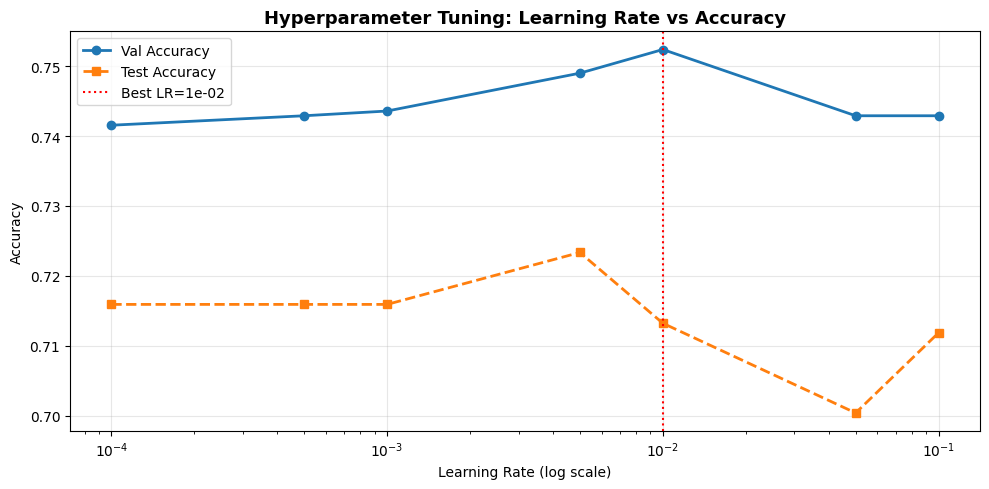

In [17]:
# ─────────────────────────────────────────────────────────
# Grid Search over Learning Rates
# ─────────────────────────────────────────────────────────
learning_rates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
TUNE_EPOCHS    = 50
results        = []

print('🔍 Hyperparameter Tuning — Learning Rate Search')
print('=' * 55)

for lr in learning_rates:
    # Fresh model for each LR
    m = LogisticRegressionModel(input_dim).to(device)
    opt = optim.Adam(m.parameters(), lr=lr, weight_decay=1e-4)

    best_val_acc = 0.0
    for epoch in range(1, TUNE_EPOCHS + 1):
        m.train()
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            loss = criterion(m(X_batch), y_batch)
            loss.backward()
            opt.step()

        m.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                preds    = m(X_batch)
                correct += ((preds >= 0.5).float() == y_batch).sum().item()
                total   += X_batch.size(0)
        val_acc = correct / total
        if val_acc > best_val_acc:
            best_val_acc = val_acc

    # Test accuracy with best val checkpoint
    m.eval()
    with torch.no_grad():
        y_p = (m(X_test_t).cpu().numpy().flatten() >= 0.5).astype(int)
    test_acc = (y_p == y_true).mean()

    results.append({'lr': lr, 'val_acc': best_val_acc, 'test_acc': test_acc})
    print(f'  LR={lr:.0e} | Best Val Acc: {best_val_acc:.4f} | Test Acc: {test_acc:.4f}')

results_df = pd.DataFrame(results)
best_row   = results_df.loc[results_df['val_acc'].idxmax()]
best_lr    = best_row['lr']

print(f'\n🏆 Best Learning Rate: {best_lr:.0e}')
print(f'   Val Acc:  {best_row["val_acc"]:.4f}')
print(f'   Test Acc: {best_row["test_acc"]:.4f}')

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogx(results_df['lr'], results_df['val_acc'],  'o-', label='Val Accuracy',  linewidth=2)
ax.semilogx(results_df['lr'], results_df['test_acc'], 's--', label='Test Accuracy', linewidth=2)
ax.axvline(best_lr, color='red', linestyle=':', linewidth=1.5, label=f'Best LR={best_lr:.0e}')
ax.set_xlabel('Learning Rate (log scale)')
ax.set_ylabel('Accuracy')
ax.set_title('Hyperparameter Tuning: Learning Rate vs Accuracy', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# ─────────────────────────────────────────────────────────
# Re-train final model with best LR for longer epochs
# ─────────────────────────────────────────────────────────
print(f'🚀 Re-training final model with best LR = {best_lr:.0e}...')
final_model = LogisticRegressionModel(input_dim).to(device)
final_opt   = optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=1e-4)
final_sched = optim.lr_scheduler.ReduceLROnPlateau(final_opt, patience=10, factor=0.5)

final_history = train_model(final_model, train_loader, val_loader,
                            final_opt, criterion, epochs=150)

final_model.eval()
with torch.no_grad():
    y_probs_final = final_model(X_test_t).cpu().numpy().flatten()
    y_preds_final = (y_probs_final >= 0.5).astype(int)

print(f'\n✅ Final Model Test Accuracy: {(y_preds_final == y_true).mean():.4f}')
print(classification_report(y_true, y_preds_final, target_names=['Red Wins', 'Blue Wins']))

🚀 Re-training final model with best LR = 1e-02...
Epoch [ 10/150] | Train Loss: 0.5339, Acc: 0.7296 | Val Loss: 0.5235, Acc: 0.7307
Epoch [ 20/150] | Train Loss: 0.5343, Acc: 0.7305 | Val Loss: 0.5292, Acc: 0.7348
Epoch [ 30/150] | Train Loss: 0.5334, Acc: 0.7284 | Val Loss: 0.5219, Acc: 0.7449
Epoch [ 40/150] | Train Loss: 0.5336, Acc: 0.7312 | Val Loss: 0.5246, Acc: 0.7422
Epoch [ 50/150] | Train Loss: 0.5334, Acc: 0.7312 | Val Loss: 0.5230, Acc: 0.7476
Epoch [ 60/150] | Train Loss: 0.5343, Acc: 0.7294 | Val Loss: 0.5219, Acc: 0.7361
Epoch [ 70/150] | Train Loss: 0.5342, Acc: 0.7302 | Val Loss: 0.5238, Acc: 0.7300
Epoch [ 80/150] | Train Loss: 0.5334, Acc: 0.7341 | Val Loss: 0.5235, Acc: 0.7476
Epoch [ 90/150] | Train Loss: 0.5344, Acc: 0.7319 | Val Loss: 0.5228, Acc: 0.7510
Epoch [100/150] | Train Loss: 0.5351, Acc: 0.7300 | Val Loss: 0.5220, Acc: 0.7415
Epoch [110/150] | Train Loss: 0.5337, Acc: 0.7302 | Val Loss: 0.5233, Acc: 0.7361
Epoch [120/150] | Train Loss: 0.5340, Acc: 0.728

---
## 1.8 🔬 Feature Importance Analysis

📊 Top 15 Most Important Features (by |weight|):
              Feature    Weight  Abs_Weight
          redGoldDiff -0.275930    0.275930
       blueGoldPerMin  0.260174    0.260174
         redTotalGold -0.256333    0.256333
         blueGoldDiff  0.242366    0.242366
        blueTotalGold  0.232957    0.232957
   redTotalExperience -0.203928    0.203928
    redExperienceDiff -0.155809    0.155809
        redGoldPerMin -0.147208    0.147208
redTotalMinionsKilled  0.132967    0.132967
          blueDragons  0.123408    0.123408
   blueExperienceDiff  0.103256    0.103256
         blueAvgLevel  0.102263    0.102263
            blueKills -0.101882    0.101882
          blueAssists -0.089481    0.089481
             redKills  0.088833    0.088833


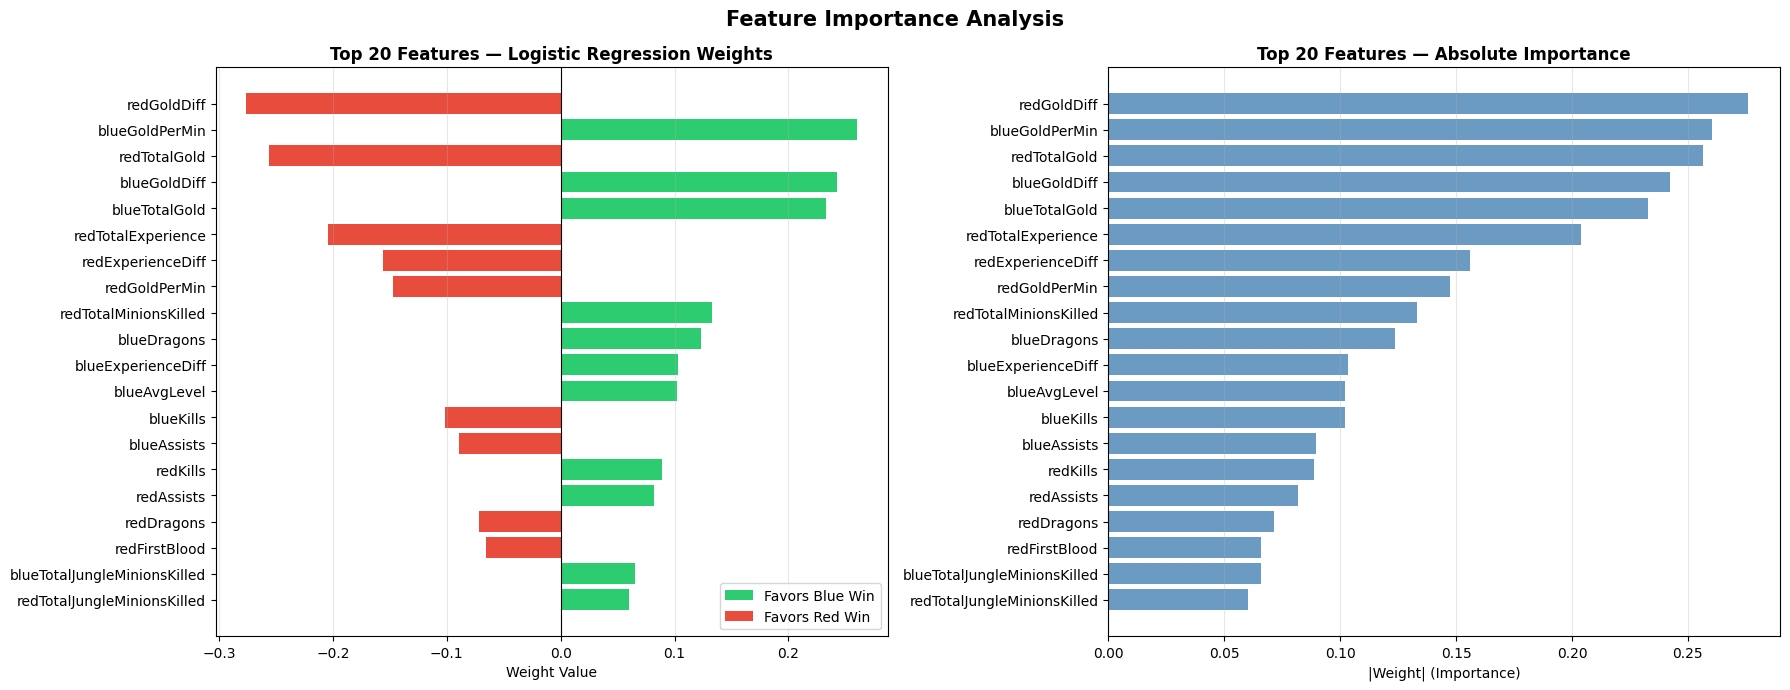

In [19]:
# ─────────────────────────────────────────────────────────
# Method 1: Weight-based Feature Importance
# In logistic regression, |weight| ∝ importance
# ─────────────────────────────────────────────────────────
weights = final_model.linear.weight.data.cpu().numpy().flatten()

importance_df = pd.DataFrame({
    'Feature':    feature_names,
    'Weight':     weights,
    'Abs_Weight': np.abs(weights)
}).sort_values('Abs_Weight', ascending=False)

print('📊 Top 15 Most Important Features (by |weight|):')
print(importance_df.head(15).to_string(index=False))

# Plot Top 20
top_n = min(20, len(feature_names))
top_features = importance_df.head(top_n)

colors = ['#2ecc71' if w > 0 else '#e74c3c' for w in top_features['Weight']]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Bar chart of weights
bars = axes[0].barh(top_features['Feature'][::-1],
                    top_features['Weight'][::-1], color=colors[::-1])
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].set_xlabel('Weight Value')
axes[0].set_title(f'Top {top_n} Features — Logistic Regression Weights',
                  fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Favors Blue Win'),
                   Patch(facecolor='#e74c3c', label='Favors Red Win')]
axes[0].legend(handles=legend_elements, loc='lower right')

# Absolute importance bar chart
axes[1].barh(top_features['Feature'][::-1],
             top_features['Abs_Weight'][::-1],
             color='steelblue', alpha=0.8)
axes[1].set_xlabel('|Weight| (Importance)')
axes[1].set_title(f'Top {top_n} Features — Absolute Importance',
                  fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

Baseline Accuracy: 0.7193

📊 Top 15 Features by Permutation Importance:
                     Feature  Importance_Drop
               redGoldPerMin         0.012146
              blueGoldPerMin         0.010796
                   blueKills         0.009447
                 redGoldDiff         0.007422
          blueExperienceDiff         0.006748
                blueGoldDiff         0.006073
          redTotalExperience         0.005398
                 blueDragons         0.004723
 redTotalJungleMinionsKilled         0.004049
                blueAvgLevel         0.004049
blueTotalJungleMinionsKilled         0.002699
      blueTotalMinionsKilled         0.002024
                  redDragons         0.002024
                 blueAssists         0.001350
                 redCSPerMin         0.001350


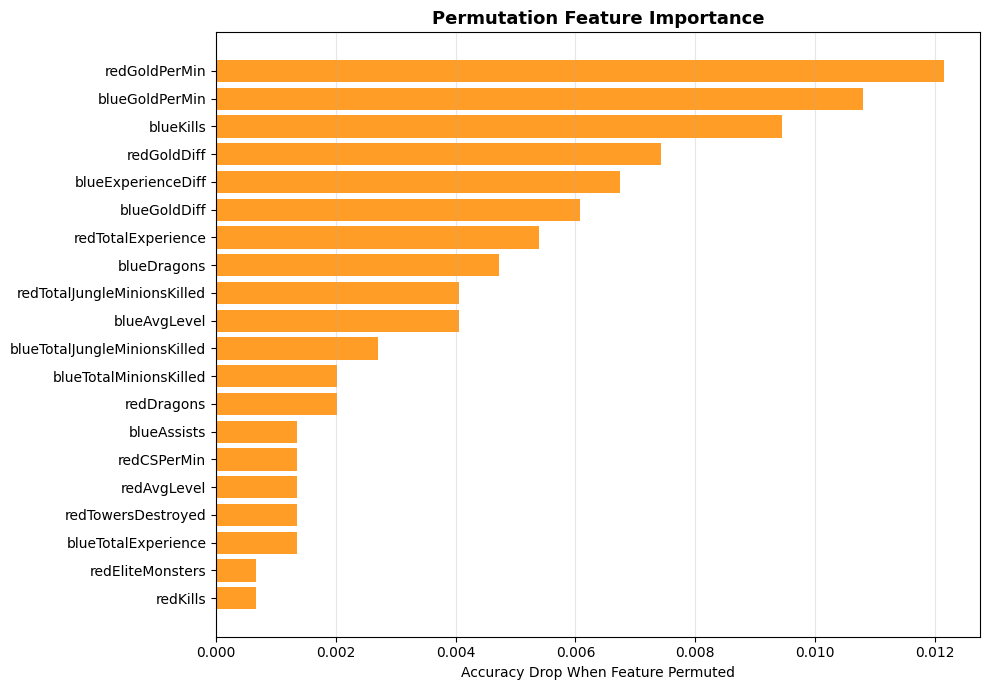

In [20]:
# ─────────────────────────────────────────────────────────
# Method 2: Permutation Feature Importance
# Shuffle each feature and measure accuracy drop
# ─────────────────────────────────────────────────────────

final_model.eval()
baseline_acc = (y_preds_final == y_true).mean()

perm_importances = []
X_test_np = X_test_scaled.copy()

for i, feat in enumerate(feature_names):
    X_permuted = X_test_np.copy()
    np.random.shuffle(X_permuted[:, i])

    X_perm_t = to_tensor(X_permuted)
    with torch.no_grad():
        preds = (final_model(X_perm_t).cpu().numpy().flatten() >= 0.5).astype(int)
    perm_acc = (preds == y_true).mean()
    perm_importances.append(baseline_acc - perm_acc)

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Drop': perm_importances
}).sort_values('Importance_Drop', ascending=False)

print(f'Baseline Accuracy: {baseline_acc:.4f}')
print('\n📊 Top 15 Features by Permutation Importance:')
print(perm_df.head(15).to_string(index=False))

# Plot
top_perm = perm_df.head(min(20, len(feature_names)))
plt.figure(figsize=(10, 7))
plt.barh(top_perm['Feature'][::-1],
         top_perm['Importance_Drop'][::-1],
         color='darkorange', alpha=0.85)
plt.xlabel('Accuracy Drop When Feature Permuted')
plt.title('Permutation Feature Importance', fontsize=13, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()